# NOTES:
* This code is based on IDCH-Multiple_Metrics.ipynb that I prepared to compare different habit indices.

# IMPORTANT: about the habit app:
* 106 did not get to the manipulations on day 5 (still_valued_post_deval)! But I have their data here.
* 109, 112, 113, 114 did not pass consumption test
* (101, 102, 108 did not pass consumption test but the opposite: no slips, maybe thought it is not applied...)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import datetime
from datetime import date, datetime
import pickle

# test correlation Pearson and Spearman:
from scipy.stats import pearsonr
from scipy.stats import spearmanr


pd.set_option('display.max_columns', None)

# Functions

In [31]:
def get_p_value_notation(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    elif p_value < 0.1:
        return '+'
    else:
        return ' '

# print the correlation on the plot, including significance:
def corrlate_vars(data, var1, var2):
    # remove row with NaN values in one of the columns:
    data = data.dropna(subset=[var1, var2])
    
    # set figure size:
    sns.jointplot(data=data, x=var1, y=var2, kind="reg", scatter_kws={'alpha':0.5})
    corr, p_value = pearsonr(data[var1], data[var2])
    p_value_note = get_p_value_notation(p_value)
    plt.text(0.1, 0.9, '   r=%.3f %s' % (corr, p_value_note), ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.show()

    sns.jointplot(data=data, x=var2, y=var1, kind="reg", scatter_kws={'alpha':0.5})
    plt.text(0.1, 0.9, '   r=%.3f %s' % (corr, p_value_note), ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.show()

    # Pearson (with p-value)
    print('Pearson correlation: %.3f' % corr)
    print('p-value: %.3f' % p_value)

    # Spearman (with p-value)
    corr, p_value = spearmanr(data[var1], data[var2])
    print('Spearman correlation: %.3f' % corr)
    print('p-value: %.3f' % p_value)
    print('---------------------------------')


# Load data

In [32]:
# DTH data:
DTH_main_data = pd.read_pickle('data/behav_data/main_data_df.pkl')
DTH_gambles = pd.read_pickle('data/behav_data/gambles.pkl')
DTH_CT_data = pd.read_pickle('data/behav_data/CT_data.pkl')
DTH_deval_summary = pd.read_csv('data/behav_data/deval_data_summary_data.csv')

# App data (csv):
App_all_data_for_R = pd.read_csv('data/behav_data/all_data_for_R.csv')
App_core_table = pd.read_csv('data/behav_data/core_table.csv')
App_filteredDF = pd.read_csv('data/behav_data/filteredDF.csv')

# diary data:
diary_IAI_summary_data = pd.read_csv('data/behav_data/diary_summary_data.csv')

# EMA summary data:
EMA_summary_data = pd.read_csv('data/behav_data/EMA_sub_avgs.csv')

# Analaysis

In [33]:
DTH_deval_summary
# remove pre_test:
DTH_deval_summary = DTH_deval_summary[DTH_deval_summary['phase'] != 'pre_test']
# remove still_valued:
DTH_deval_summary = DTH_deval_summary[DTH_deval_summary['stim_condition'] != 'still_valued']
# remove stim_condition column:
DTH_deval_summary = DTH_deval_summary.drop(columns=['stim_condition','group'])
# now make sequenceCompleted and at_least_one_response for each value of phase (and remove the phase column):
DTH_deval_summary = DTH_deval_summary.pivot(index='sub', columns='phase', values=['sequenceCompleted','at_least_one_response'])
DTH_deval_summary.columns = ['_'.join(col).strip() for col in DTH_deval_summary.columns.values]
DTH_deval_summary = DTH_deval_summary.reset_index()
DTH_deval_summary
# reorder columns such that the _test are before the reacquisition ones:
DTH_deval_summary = DTH_deval_summary.loc[:,['sub', 'sequenceCompleted_test', 'sequenceCompleted_reacquisition', 'at_least_one_response_test', 'at_least_one_response_reacquisition']]
# change sub to subID:
DTH_deval_summary = DTH_deval_summary.rename(columns={'sub':'subID'})
# now add a column after sequenceCompleted_reacquisition of sequenceCompleted_combined:
DTH_deval_summary['sequenceCompleted_combined'] = DTH_deval_summary['sequenceCompleted_test'] + DTH_deval_summary['sequenceCompleted_reacquisition']
# now add a column after at_least_one_response_reacquisition of at_least_one_response_combined:
DTH_deval_summary['at_least_one_response_combined'] = DTH_deval_summary['at_least_one_response_test'] + DTH_deval_summary['at_least_one_response_reacquisition']
# place them:
DTH_deval_summary = DTH_deval_summary.loc[:,['subID', 'sequenceCompleted_test', 'sequenceCompleted_reacquisition', 'sequenceCompleted_combined', 'at_least_one_response_test', 'at_least_one_response_reacquisition', 'at_least_one_response_combined']]

DTH_deval_summary

,subID,sequenceCompleted_test,sequenceCompleted_reacquisition,sequenceCompleted_combined,at_least_one_response_test,at_least_one_response_reacquisition,at_least_one_response_combined
0,101,1,11,12,1,11,12
1,102,0,0,0,0,0,0
2,103,0,0,0,0,0,0
3,104,0,0,0,0,0,0
4,105,3,0,3,4,0,4
5,106,1,0,1,2,0,2
6,107,0,0,0,0,0,0
7,108,0,0,0,0,0,0
8,109,0,0,0,0,0,0
9,110,0,0,0,1,0,1


In [34]:
for zz in App_all_data_for_R.columns:
    print(zz)



subID
group
devaluation
still_valued
still_valued_post_deval
mean_still_valued
mean_still_valued_all
devaluation_SQRT
still_valued_SQRT
still_valued_post_deval_SQRT
mean_still_valued_SQRT
mean_still_valued_all_SQRT
postVal_minus_deval
stillVal_minus_deval
stillVal_minus_postVal
preVal_relativeDiff_deval
postVal_relativeDiff_deval
preVal_relativeDiff_deval_SQRT
postVal_relativeDiff_deval_SQRT
meanVal_minus_deval
meanAllVal_minus_deval
meanVal_minus_deval_SQRT
meanAllVal_minus_deval_SQRT
meanVal_relativeDiff_deval
meanAllVal_relativeDiff_deval
meanVal_relativeDiff_deval_SQRT
meanAllVal_relativeDiff_deval_SQRT
prcChange_preToDeval
prcChange_preToPost
preVal_relativeDiff_postVal
preVal_relativeDiff_postVal_SQRT
STD_entriesAcrossNoDevalDays
SEM_entriesAcrossNoDevalDays
NormedSTD_entriesAcrossNoDevalDays
NormedVar_entriesAcrossNoDevalDays
firstDayEntries
allEntries
STD_entriesAcrossNoManipulationDays
SEM_entriesAcrossNoManipulationDays
NormedSTD_entriesAcrossNoManipulationDays
NormedVar_entr

In [35]:
App_all_data_for_R_main = App_all_data_for_R.loc[:,['subID', 'devaluation', 'stillVal_minus_deval', 'preVal_relativeDiff_deval', 'meanVal_minus_deval', 'meanVal_relativeDiff_deval', 'meanVal_relativeDiff_deval_SQRT']]
App_all_data_for_R_main

,subID,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,meanVal_minus_deval,meanVal_relativeDiff_deval,meanVal_relativeDiff_deval_SQRT
0,101,0,34,1.000000,34.5,1.000000,1.000000
1,102,0,5,1.000000,4.0,1.000000,1.000000
2,103,6,1,0.076923,-1.0,-0.090909,-0.045549
3,104,3,12,0.666667,6.5,0.520000,0.280449
4,105,0,9,1.000000,8.0,1.000000,1.000000
5,106,4,26,0.764706,11.0,0.578947,0.318915
6,107,0,10,1.000000,6.5,1.000000,1.000000
7,108,0,3,1.000000,2.5,1.000000,1.000000
8,109,2,25,0.862069,15.5,0.794872,0.494699
9,110,7,7,0.333333,2.0,0.125000,0.062746


In [36]:
EMA_summary_data

,subID,mood,Anxiety,Stress,routine_mean
0,101.0,71.985294,34.367647,26.191176,3.593137
1,102.0,68.357143,22.000000,21.828571,3.638095
2,103.0,63.100000,20.471429,18.957143,3.823810
3,104.0,68.457143,14.714286,14.814286,4.095238
4,105.0,62.536232,33.927536,42.318841,4.376812
5,106.0,90.724138,3.896552,9.327586,5.902299
6,107.0,66.402985,42.507463,37.104478,4.457711
7,108.0,70.609375,25.718750,15.906250,5.072917
8,109.0,86.630769,3.384615,5.400000,5.907692
9,110.0,66.428571,12.442857,28.271429,5.219048


In [37]:
App_all_data_for_R_main

,subID,devaluation,stillVal_minus_deval,preVal_relativeDiff_deval,meanVal_minus_deval,meanVal_relativeDiff_deval,meanVal_relativeDiff_deval_SQRT
0,101,0,34,1.000000,34.5,1.000000,1.000000
1,102,0,5,1.000000,4.0,1.000000,1.000000
2,103,6,1,0.076923,-1.0,-0.090909,-0.045549
3,104,3,12,0.666667,6.5,0.520000,0.280449
4,105,0,9,1.000000,8.0,1.000000,1.000000
5,106,4,26,0.764706,11.0,0.578947,0.318915
6,107,0,10,1.000000,6.5,1.000000,1.000000
7,108,0,3,1.000000,2.5,1.000000,1.000000
8,109,2,25,0.862069,15.5,0.794872,0.494699
9,110,7,7,0.333333,2.0,0.125000,0.062746


In [38]:
# merge the two dataframes:
merged_DTH_App = pd.merge(DTH_deval_summary, App_all_data_for_R_main, on='subID')
merged_DTH_App = pd.merge(merged_DTH_App, diary_IAI_summary_data, on='subID', how='outer')
merged_DTH_App = pd.merge(merged_DTH_App, EMA_summary_data, on='subID', how='outer')

# # # remove subID 109, 112, 111, 114:
# merged_DTH_App = merged_DTH_App[~merged_DTH_App['subID'].isin([109, 112, 113, 114])]

# Habit app vs DTH

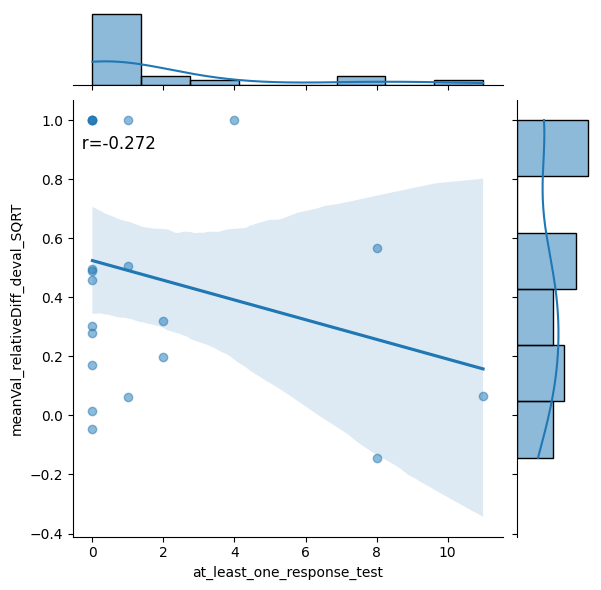

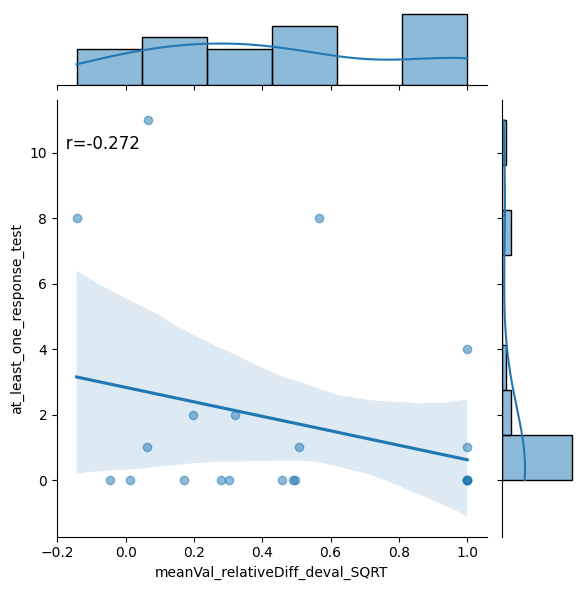

Pearson correlation: -0.272
p-value: 0.234
Spearman correlation: -0.150
p-value: 0.518
---------------------------------


In [39]:
# corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'preVal_relativeDiff_deval')
# corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'meanVal_relativeDiff_deval')
corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'meanVal_relativeDiff_deval_SQRT')


# Diary STD vs. app and DTH

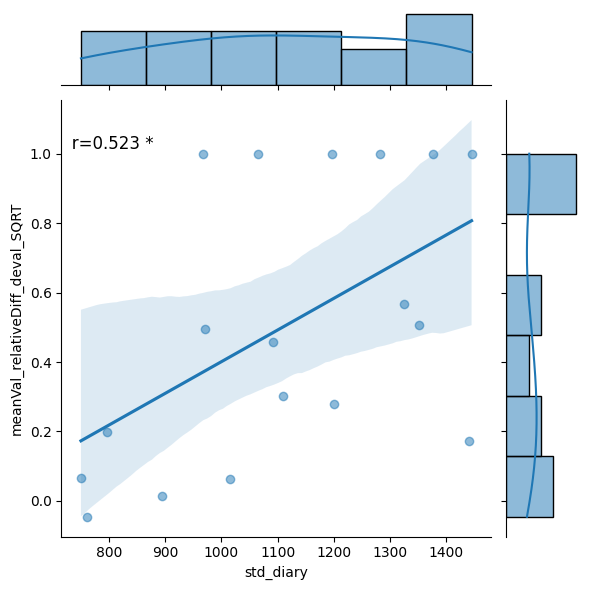

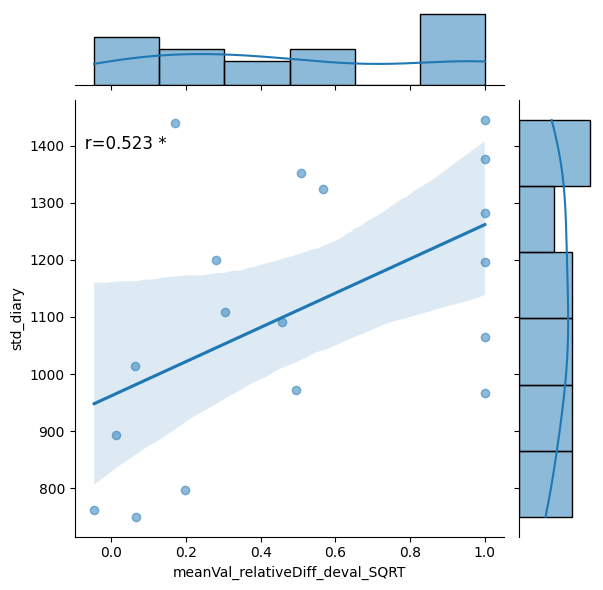

Pearson correlation: 0.523
p-value: 0.026
Spearman correlation: 0.530
p-value: 0.024
---------------------------------


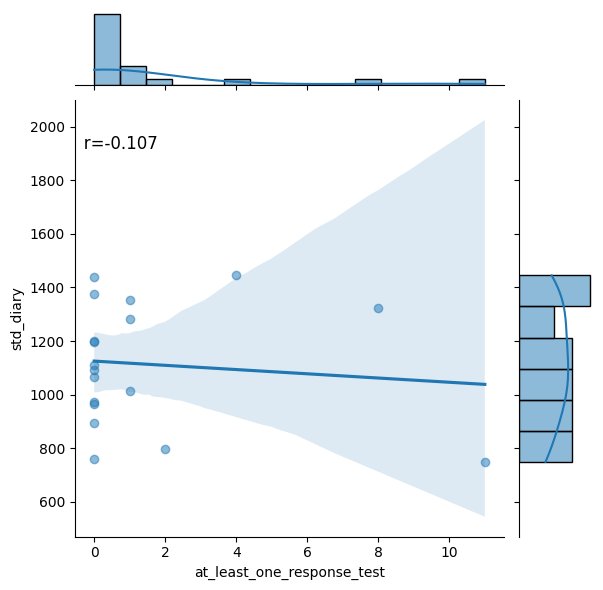

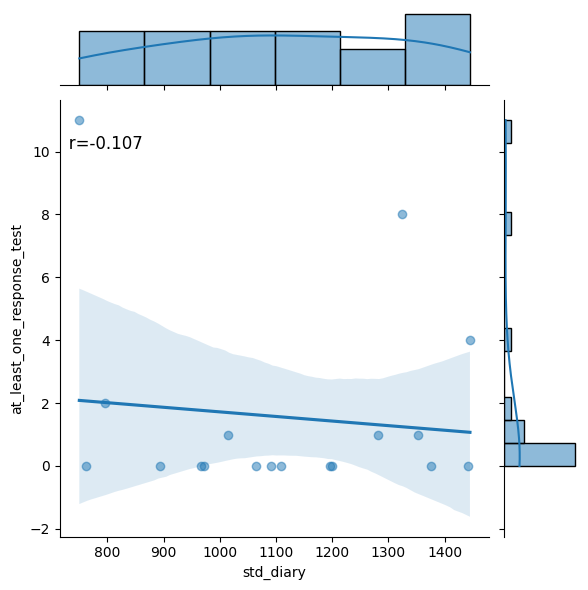

Pearson correlation: -0.107
p-value: 0.672
Spearman correlation: 0.046
p-value: 0.856
---------------------------------


In [40]:
# corrlate_vars(merged_DTH_App, 'std_diary', 'preVal_relativeDiff_deval')
# corrlate_vars(merged_DTH_App, 'std_diary', 'meanVal_relativeDiff_deval')
corrlate_vars(merged_DTH_App, 'std_diary', 'meanVal_relativeDiff_deval_SQRT')

corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'std_diary')

# SRM score vs. app and DTH

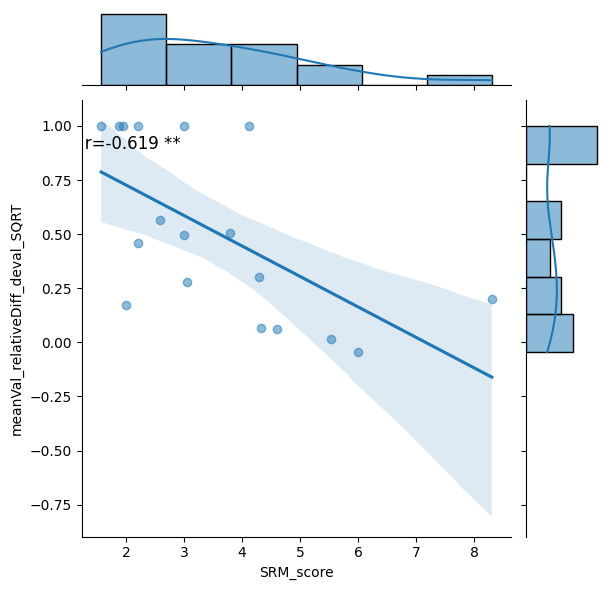

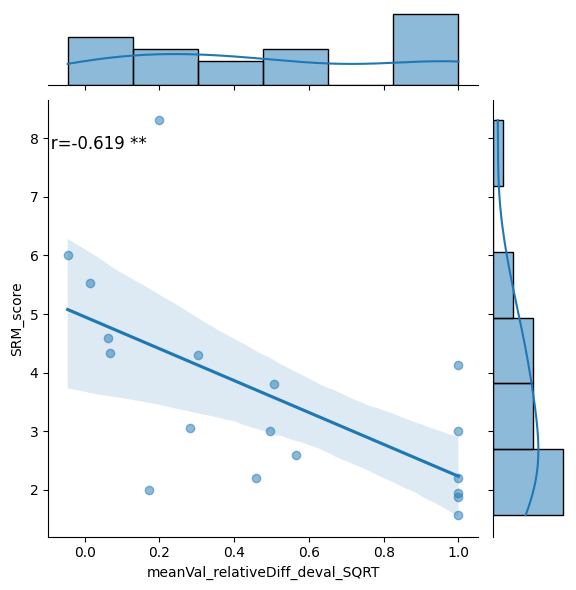

Pearson correlation: -0.619
p-value: 0.006
Spearman correlation: -0.716
p-value: 0.001
---------------------------------


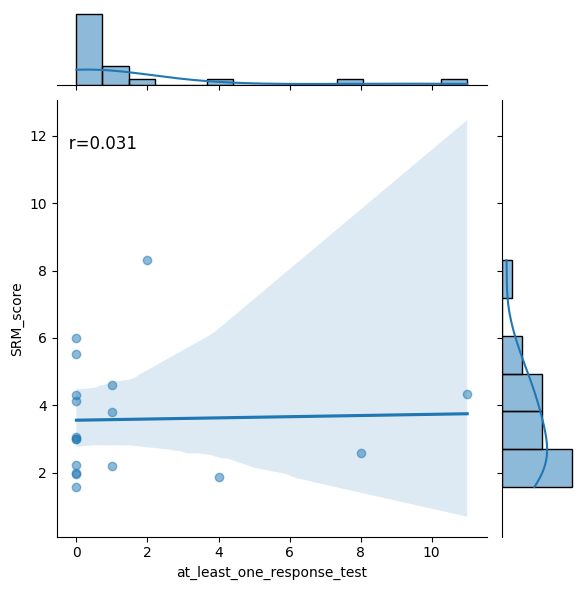

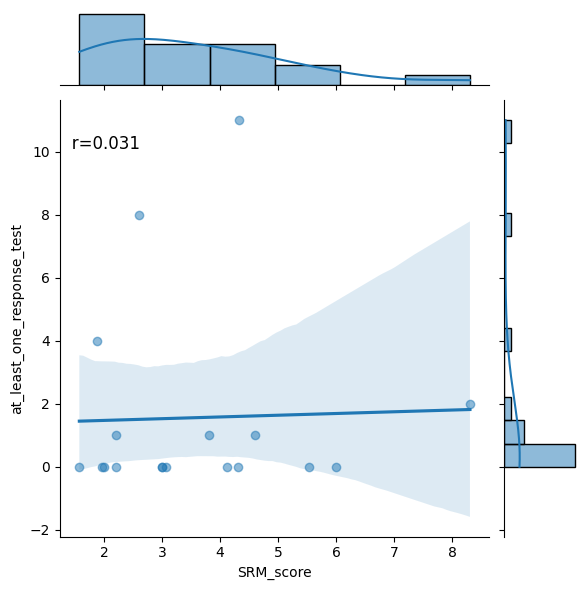

Pearson correlation: 0.031
p-value: 0.903
Spearman correlation: 0.107
p-value: 0.672
---------------------------------


In [41]:
# corrlate_vars(merged_DTH_App, 'SRM_score', 'preVal_relativeDiff_deval')
# corrlate_vars(merged_DTH_App, 'SRM_score', 'meanVal_relativeDiff_deval')
corrlate_vars(merged_DTH_App, 'SRM_score', 'meanVal_relativeDiff_deval_SQRT')

corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'SRM_score')

# Now Routine EMA score

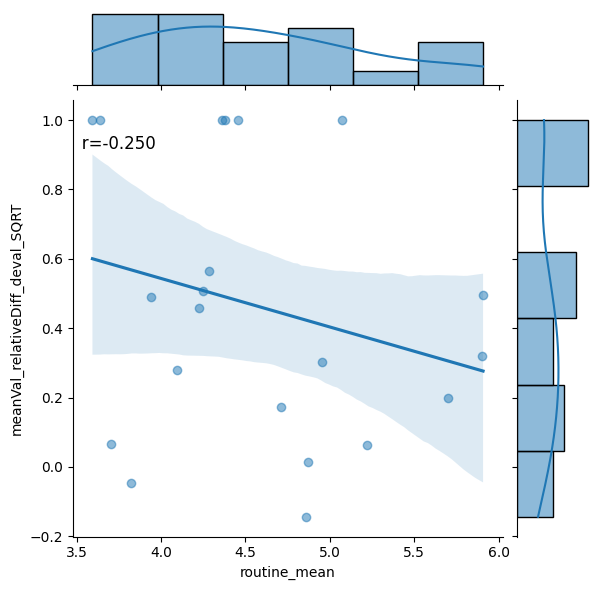

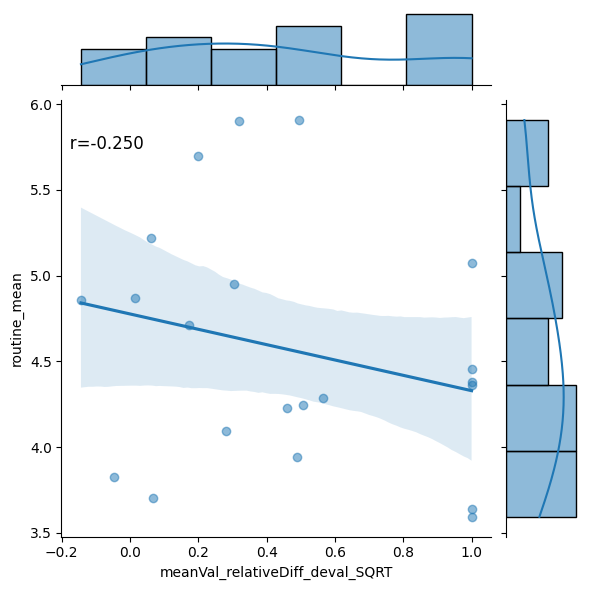

Pearson correlation: -0.250
p-value: 0.274
Spearman correlation: -0.192
p-value: 0.403
---------------------------------


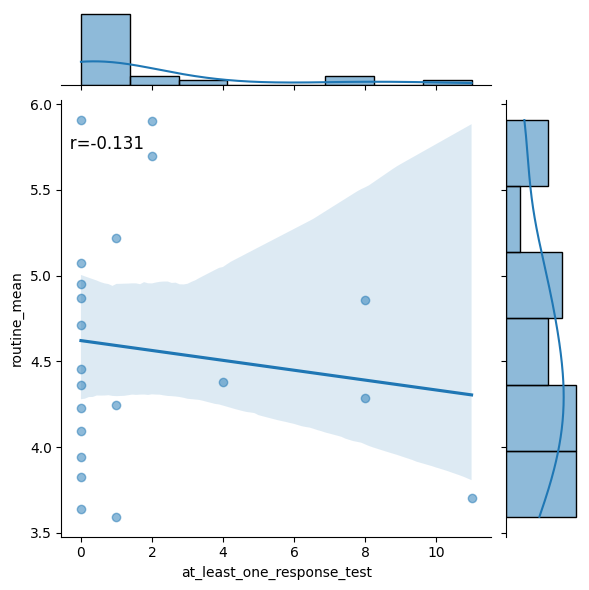

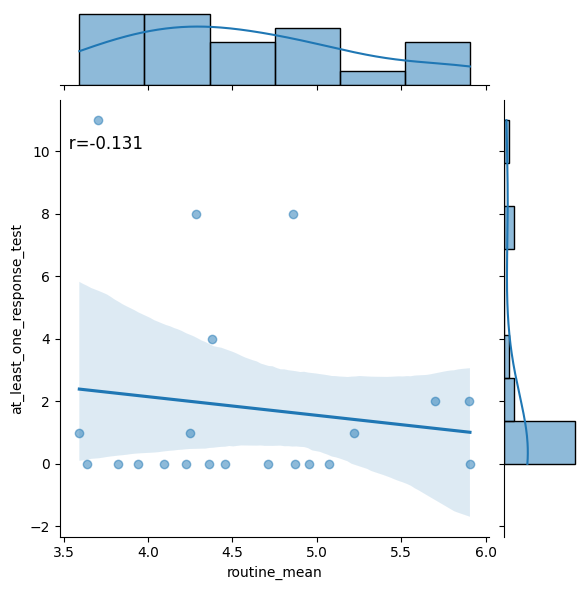

Pearson correlation: -0.131
p-value: 0.571
Spearman correlation: 0.032
p-value: 0.891
---------------------------------


In [42]:
# corrlate_vars(merged_DTH_App, 'routine_mean', 'preVal_relativeDiff_deval')
# corrlate_vars(merged_DTH_App, 'routine_mean', 'meanVal_relativeDiff_deval')
corrlate_vars(merged_DTH_App, 'routine_mean', 'meanVal_relativeDiff_deval_SQRT')

corrlate_vars(merged_DTH_App, 'at_least_one_response_test', 'routine_mean')

# Save merged data

In [43]:
# save the merged data:
merged_DTH_App.to_csv('data/behav_data/merged_behav_data.csv', index=False)